# Tutorial1: DLPFC Domains Detection with GLAND
This notebook demonstrates the workflow for using the GLAND model to identify spatial domains in Visium datasets.

## Environment Configuration


In [1]:
#First, we import the necessary libraries and configure the computation device. We also set the R_HOME environment variable to ensure mclust (required for clustering) functions correctly within the Python environment.
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score
from GLAND import GLAND
from GLAND.utils import clustering

# Set computation device (GPU is highly recommended for GLAND training)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure R environment for mclust algorithm
# Path automatically mapped to your GraphST-main conda environment
os.environ['R_HOME'] = r'/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/R'

Using device: cuda:3


## Data Loading and Preprocessing

In [2]:
#We will use the DLPFC (151672) dataset as an example. This step involves loading the Visium data and ensuring the gene names are unique.
# Configuration
dataset = '151672'
n_clusters = 5  # Number of layers/clusters expected
file_fold = r'/mnt/first19T/liufk/x/'  # Path to your data directory

# Load Visium data
adata = sc.read_visium(os.path.join(file_fold, dataset), load_images=True)
adata.var_names_make_unique()
print(f"Successfully loaded dataset {dataset}")
adata

/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Successfully loaded dataset 151672


AnnData object with n_obs × n_vars = 4015 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Model Training and Spatial Clustering

Total number of points before filtering: 4015

Filtering using a fixed threshold: 1.8

Total number of points after filtering: 4013
Number of points filtered out: 2


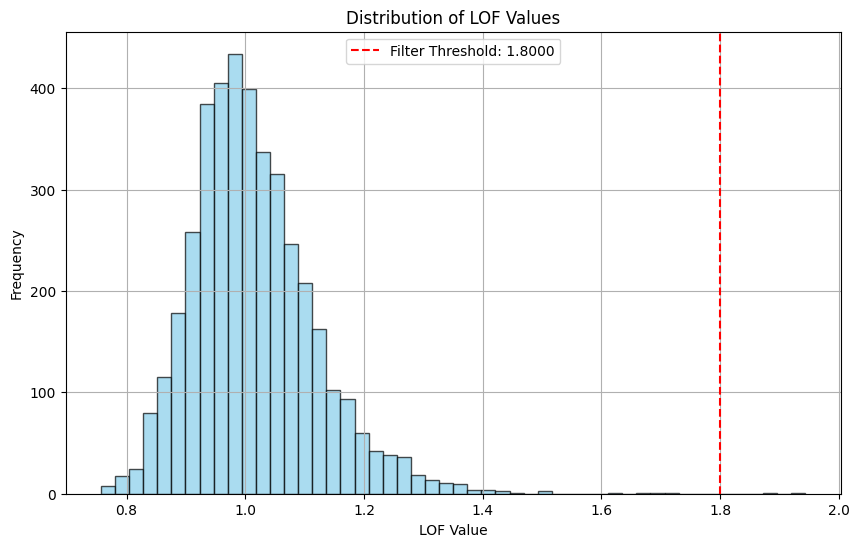

/mnt/first19T/liufk/GLAND/preprocess.py:115: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


Begin to train ST data...


 40%|████████████████████████████▊                                           | 200/500 [00:22<00:33,  8.92it/s]

Updating adjacency matrix at epoch 200...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.31it/s]


Optimization finished for ST data!


by .GlobalEnv when processing object ‘.pbd_env’
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
# Initialize the GLAND model
model = GLAND.GLAND(
    adata, 
    device=device, 
    epochs=500, 
    dataset=dataset, 
    n_clusters=n_clusters
)
# Train the model
adata = model.train()
# Clustering settings
radius = 50     # Radius for spatial refinement
# Refinement is recommended for the DLPFC dataset to reduce noise
clustering(adata, n_clusters, radius=radius, method='mclust', refinement=True) 

## Evaluation and Visualization

/tmp/ipykernel_2504589/724869231.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


151672:
ARI: 0.7850
NMI: 0.7558


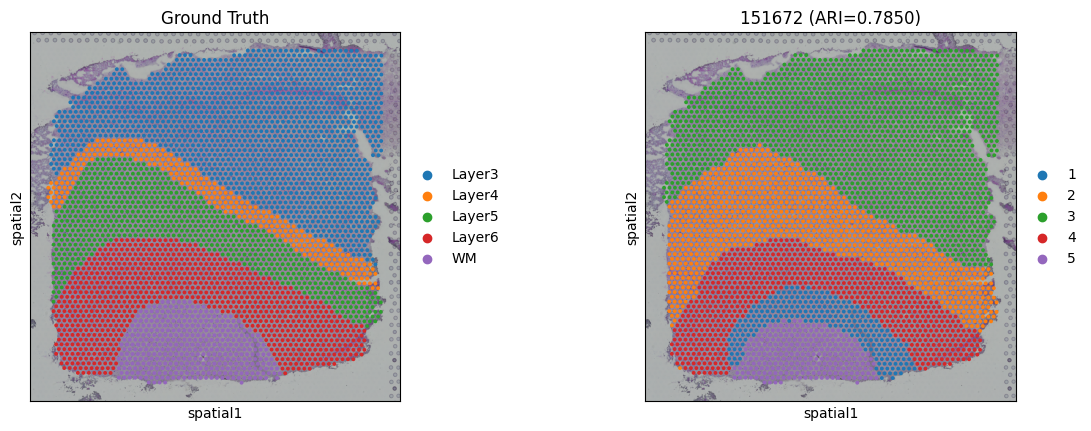

In [4]:
# Load ground truth metadata
df_meta = pd.read_csv(os.path.join(file_fold, dataset, 'metadata.tsv'), sep='\t')
adata.obs['ground_truth'] = df_meta['layer_guess'].values

# Filter out spots missing ground truth or domain labels
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
adata = adata[~pd.isnull(adata.obs['domain'])]

# Calculate Metrics
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])

# Store metrics in AnnData
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print(f'{dataset}:')
print(f'ARI: {ARI:.4f}')
print(f'NMI: {NMI:.4f}')

# Plotting spatial clustering results
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["ground_truth", "domain"],
    title=["Ground Truth", f"{dataset} (ARI={ARI:.4f})"],
    show=True
)